# DNN: analysis with Keras of 2D data

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

from sklearn.preprocessing import StandardScaler

%run useful.py

# training data
perc_train = 0.8

## Read data

(2000, 8)
8
[1.83918812 2.04560279 5.67725029 5.95544703 9.6451452  6.53177097
 7.48906638 6.53569871] 1
[7.47714809 9.61306736 0.08388298 1.06444377 2.98703714 6.56411183
 8.09812553 8.72175914] 0
[9.64647597 7.23685347 6.42475328 7.17453621 4.67599007 3.25584678
 4.39644606 7.29689083] 0
[9.94014586 6.76873712 7.90822518 1.70914258 0.26849276 8.00370244
 9.03722538 0.2467621 ] 0
[4.91747318 5.26255167 5.9636601  0.51957545 8.95089528 7.2826618
 8.18350011 5.00222753] 1
data: 2000
train: 1600


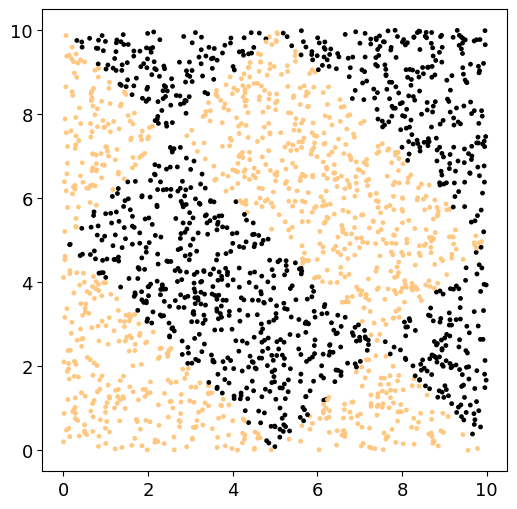

In [2]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])
print(L)

for i in range(5):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [3]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


#  Hyperparameter Tuning and Cross-Validation


The `build_model(hp)` function describes a Keras model with:
- **Optimizer**: A choice among `"adam"`, `"rmsprop"`, or `"nesterov"`.
- **Learning rate**: A choice among `[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`.
- **Activation**: A choice among `["relu", "sigmoid", "elu"]`.
- **Dropout rate**: A choice among `[0.0, 0.1, 0.2]`.



## Random Search (Single-Split)
We instantiate `keras_tuner.RandomSearch` with:
- An **objective** of `"val_accuracy"`, meaning the tuner tries to maximize validation accuracy.
- A `max_trials` value that limits how many random hyperparameter configurations are tested.
- `executions_per_trial=1`, meaning we train and evaluate the model once for each trial.



## Retrieving the Top 3 Hyperparameters
After the random search, we do:
```python
top_3_hps = tuner.get_best_hyperparameters(3)
```
to get the 3 best performing sets of hyperparamiters and perform a cross validation with a higher number of epochs to select the most promising one


In [4]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner
from sklearn.model_selection import KFold



# Reproducibility
np.random.seed(12345)
tf.random.set_seed(12345)

# Train/Validation Split
x_train, y_train = x[:N_train], y[:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]

print("Train:", len(x_train), "\t Validation:", len(x_valid))


def build_model(hp):

    model = Sequential()

    # Hyperparameters to tune:
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "nesterov"])
    learning_rate = hp.Choice("learning_rate", [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    dense_activation = hp.Choice("dense_activation", ["relu", "sigmoid", "elu"])
    dropout_rate = hp.Choice("dropout", [0.0, 0.1, 0.2])

    
    input_dim = x_train.shape[1]
    model.add(Dense(input_dim, input_shape=(input_dim,), activation=dense_activation))
    model.add(Dense(20, activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation=dense_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer_choice == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "nesterov":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model


MAX_TRIALS = 20 # needs to be increased given a lot of possible combinations of hyperparameters

tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=MAX_TRIALS,
    executions_per_trial=1,       
    directory="my_random_search", 
    project_name="tune_dnn"
)

tuner.search(
    x_train, y_train,
    epochs=50,  # shorter search
    validation_data=(x_valid, y_valid),
    verbose=0
)

# Now let's choose the 3 best perfoming

top_3_hps = tuner.get_best_hyperparameters(3)
print("\nTop-3 hyperparameter combinations (based on single-split validation accuracy):")
for i, hps in enumerate(top_3_hps, start=1):
    print(f"--- Model #{i} ---")
    print("Optimizer:", hps.get("optimizer"))
    print("Learning rate:", hps.get("learning_rate"))
    print("Dense activation:", hps.get("dense_activation"))
    print("Dropout rate:", hps.get("dropout"))
    print("---------------------------------------------")


def cross_val_accuracy(hps, x_data, y_data, folds=5, epochs=300, batch_size=32):

    kfold = KFold(n_splits=folds, shuffle=True, random_state=12345)
    fold_accuracies = []

    for train_idx, val_idx in kfold.split(x_data):
        x_tr, x_val = x_data[train_idx], x_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model = build_model(hps)
        history = model.fit(
            x_tr, y_tr,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )
        # track final epoch's validation accuracy
        fold_accuracies.append(history.history["val_accuracy"][-1])

    return np.mean(fold_accuracies)

cv_scores = []
print("\nPerforming cross-validation on these top-3 sets of hyperparameters:")
for i, hps in enumerate(top_3_hps, start=1):
    avg_acc = cross_val_accuracy(hps, x_train, y_train, folds=5, epochs=300, batch_size=32) 
    cv_scores.append(avg_acc)
    print(f"CV avg accuracy for Model #{i}: {avg_acc:.4f}")

# Now we choose the best performing model from cross-validation
best_index = np.argmax(cv_scores)
best_hps_cv = top_3_hps[best_index]
best_cv_score = cv_scores[best_index]

print(f"\n==> Best of the top-3 after cross-validation is Model #{best_index+1}, with avg CV accuracy = {best_cv_score:.4f}.")
print("Selected hyperparameters:")
print("Optimizer:", best_hps_cv.get("optimizer"))
print("Learning rate:", best_hps_cv.get("learning_rate"))
print("Dense activation:", best_hps_cv.get("dense_activation"))
print("Dropout rate:", best_hps_cv.get("dropout"))


# After finding the best parameters we build the model
final_model = build_model(best_hps_cv)





Train: 1600 	 Validation: 400
Reloading Tuner from my_random_search\tune_dnn\tuner0.json

Top-3 hyperparameter combinations (based on single-split validation accuracy):
--- Model #1 ---
Optimizer: adam
Learning rate: 0.01
Dense activation: elu
Dropout rate: 0.0
---------------------------------------------
--- Model #2 ---
Optimizer: rmsprop
Learning rate: 0.01
Dense activation: elu
Dropout rate: 0.1
---------------------------------------------
--- Model #3 ---
Optimizer: nesterov
Learning rate: 0.1
Dense activation: elu
Dropout rate: 0.1
---------------------------------------------

Performing cross-validation on these top-3 sets of hyperparameters:


c:\Users\teresa i robert\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CV avg accuracy for Model #1: 0.9137
CV avg accuracy for Model #2: 0.9475
CV avg accuracy for Model #3: 0.4969

==> Best of the top-3 after cross-validation is Model #2, with avg CV accuracy = 0.9475.
Selected hyperparameters:
Optimizer: rmsprop
Learning rate: 0.01
Dense activation: elu
Dropout rate: 0.1


## Optimization method and cost function

## Training

In [5]:
nepoch = 400
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
fit = final_model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=0)

val_loss, val_acc = final_model.evaluate(x_valid, y_valid, verbose=0)
print(f"\nFinal model validation accuracy: {val_acc:.4f}")


Final model validation accuracy: 0.9475


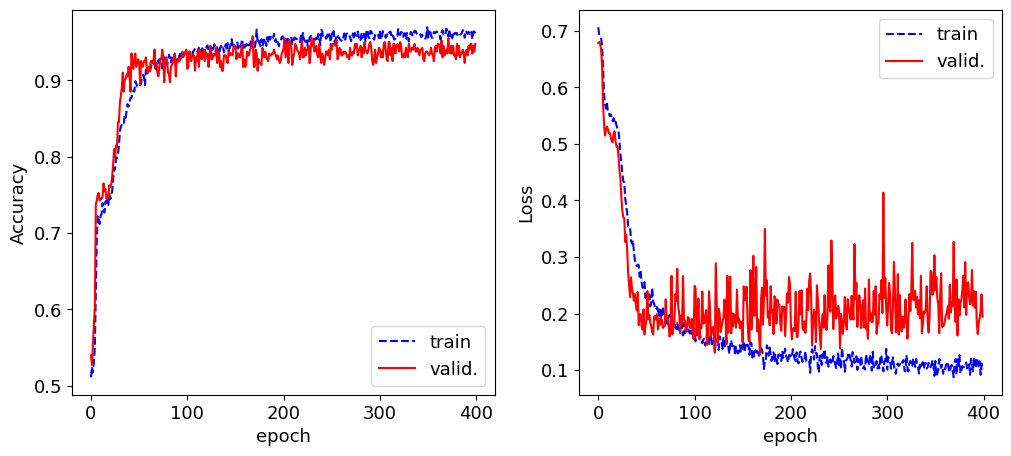

In [6]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

The network learns well from the data up to 100-th epoch, after which the accuracy on the validation set doesn't decrease and the network saturated in terms of what it can learn with this architecture

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


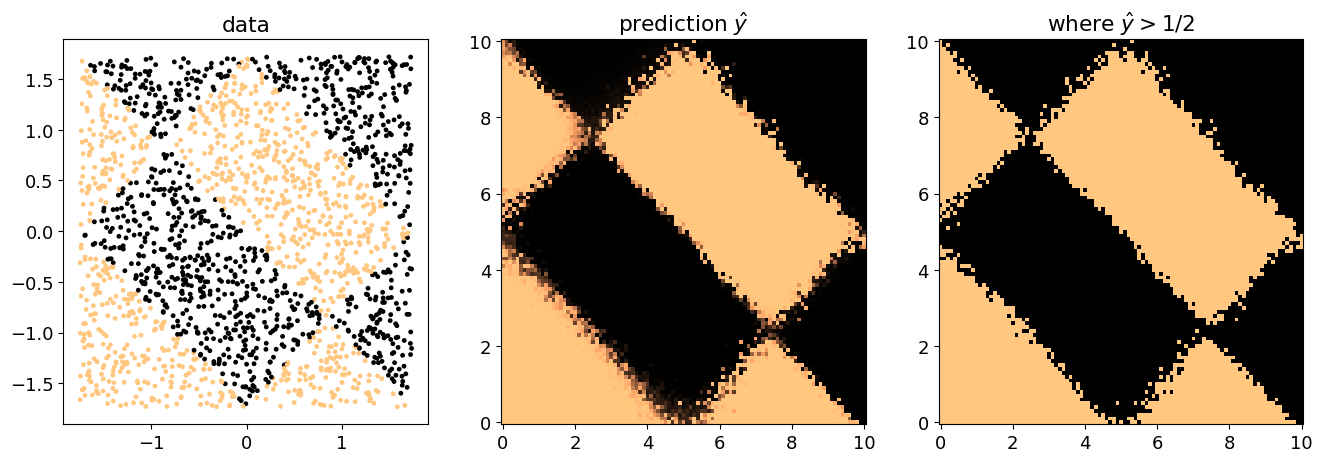

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [7]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = final_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")

## **2.a – Reducing the number of samples**


In [8]:

fractions = [0.1, 0.3, 0.5, 0.7]
performance_results = []

for f in fractions:

    subset_size = int(len(x_train) * f)


    x_train_subset = x_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    model = build_model(best_hps_cv)  
    model.fit(x_train_subset, y_train_subset, 
              epochs=300, 
              validation_data=(x_valid, y_valid),
              verbose=0)
    
    val_loss, val_acc = model.evaluate(x_valid, y_valid, verbose=0)

    performance_results.append((f, val_acc))

for f, acc in performance_results:
    print(f"Fraction {f:.1f}: Val Accuracy = {acc:.4f}")


Fraction 0.1: Val Accuracy = 0.5400
Fraction 0.3: Val Accuracy = 0.7925
Fraction 0.5: Val Accuracy = 0.9325
Fraction 0.7: Val Accuracy = 0.9400


As we can see the accuracy increases as the number of points increases

## **2.b – Augmenting the number of samples via Data Augmentation**



In [9]:
import numpy as np

def augment_data(x, noise_factor=0.01):
    # we add noise to x points but retain the same label y
    x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return x_noisy

augment_factors = [0.0, 0.3, 0.5, 1.0]
noise_factor = 0.01  

results_augment = []

for af in augment_factors:
    n_train = len(x_train)
    n_new = int(n_train * af)
    
    new_indices = np.random.choice(range(n_train), size=n_new, replace=True)
    
    x_train_aug_part = augment_data(x_train[new_indices], noise_factor=noise_factor)
    y_train_aug_part = y_train[new_indices] # same label as the training
    
    x_train_aug = np.concatenate([x_train, x_train_aug_part], axis=0)
    y_train_aug = np.concatenate([y_train, y_train_aug_part], axis=0)
   
    augmented_model = build_model(best_hps_cv)

    augmented_model.fit(
        x_train_aug, 
        y_train_aug, 
        epochs=300,       
        batch_size=32,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    val_loss, val_acc = augmented_model.evaluate(x_valid, y_valid, verbose=0)
    results_augment.append((af, val_acc))

print("Risultati Data Augmentation:")
for af, acc in results_augment:
    print(f"Augment factor = {af:.2f} --> Validation Accuracy = {acc:.4f}")


Risultati Data Augmentation:
Augment factor = 0.00 --> Validation Accuracy = 0.9575
Augment factor = 0.30 --> Validation Accuracy = 0.9500
Augment factor = 0.50 --> Validation Accuracy = 0.9575
Augment factor = 1.00 --> Validation Accuracy = 0.9375


## Observation
The validation accuracy decreased after x1.5 of the original data however different results can be obtained with different values of the noise

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


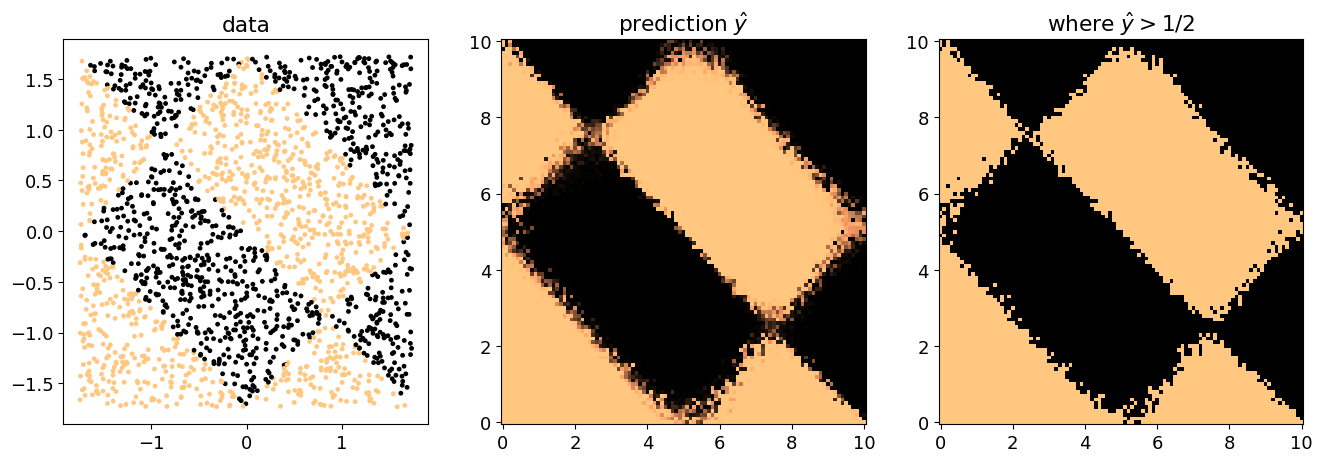

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [10]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = augmented_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")